# Simulation of a water box using the $q$-potential

This will simulate a box of SPC/E water using a custom nonbonded force based on a tabulated $q$-potential. It can also perform a simulation using Ewald summation.

Install prerequisites using `conda`:
```bash
    $ conda config --add channels omnia
    $ conda install -c omnia openmm mdtraj packmol
```

In [1]:
%matplotlib inline
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import matplotlib, matplotlib.pyplot as plt
from io import StringIO
import numpy as np, os
matplotlib.rcParams.update({'font.size': 12})

### Create initial box of water

First create a single water molecule pdb file, then use this to fill up a predefined box using the command line tool `packmol`. In this example, $N$ and $L$ are taken form the Gromacs `spc216.gro` file.

In [2]:
%%writefile hoh.pdb
CRYST1   30.000   30.000   30.000  90.00  90.00  90.00 P 1           1
ATOM      1  O   HOH A   1      27.552  11.051   7.172  1.00  0.00          O
ATOM      2  H1  HOH A   1      27.900  10.721   8.050  1.00  0.00          H
ATOM      3  H2  HOH A   1      26.606  11.355   7.281  1.00  0.00          H 
END

Overwriting hoh.pdb


In [3]:
# simulation parameters: more to be added

nsteps  = 100000   # number of MD steps
boxlen  = 18.6206 # size of the cubic box in Å
nwater  = 216     # number of water molecules
NPT     = False   # NPT ensemble using pressure coupling?

# write input file for packmol
PACKMOL_INPUT = """ 
tolerance %f
filetype pdb
output %s

# hoh will be put in a box
# defined by the minimum coordinates x, y and z = 0. 0. 0. and maximum
# coordinates box_size box_size box_size That is, they will be put in a cube of side
# box_size (the keyword "inside cube 0. 0. 0. box_size") could be used as well.

structure %s
  number %d
  inside box 0. 0. 0. %f %f %f 
  add_box_sides 0.0
end structure
""" % (2.,'box.pdb','hoh.pdb', nwater, boxlen, boxlen, boxlen)

!echo '$PACKMOL_INPUT' > packmol_input.txt
!packmol < packmol_input.txt > /dev/null

### Create OpenMM `System` classes for a variety of long-range correction schemes

Here the idea is to create all the different setups and add then to the `systemlist` dictionary. Ewald summation (and PME) can be setup using the default `NonbondedForce` class, while `CustomNonbondedForce` must be used for custom pair potentials as used in Wolf, Stenqvist etc.


_TODO_: Smoothen LJ part at $R_c$. Use switching function?

In [4]:
def findForce(system, forcetype, add=True):
    """ Finds a specific force in the system force list - added if not found."""
    for force in system.getForces():
        if isinstance(force, forcetype):
            return force
    if add==True:
        system.addForce(forcetype())
        return findForce(system, forcetype)
    return None

def make_qpotential_system(topology, Rc=0.9*nanometers):
    ''' return a q-potential system (TO BE COMPLETED) '''
    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)

    # tabulated q-potential. TO BE IMPLEMENTED!
    x = np.linspace( 0.001, 1, 1000 )
    array = 1/x - 1
    fwolf = Continuous1DFunction(array, 0*nanometers, 1*nanometers)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.addTabulatedFunction('wolf', fwolf)  # 'wolf(r)' can now be used in energy function
    nonbonded.addGlobalParameter('Rc', Rc)         # 'Rc' can now be used in energy function
    nonbonded.addGlobalParameter('lB', 0.7*80*2.5) # 'lB' bjerrum length in nm and kJ/mol
    
    nonbonded.setEnergyFunction(
        'lB*charge1*charge2*(1/r - 1/Rc + 1/Rc^2*(r-Rc))' \
        ' + 4*epsilon*((sigma/r)^12-(sigma/r)^6) ; sigma=0.5*(sigma1+sigma2); epsilon=sqrt(epsilon1*epsilon2)' )

    return system

def make_ewald_system(topology, Rc=0.9*nanometers):
    ''' returns an Ewald system '''
    ff = ForceField('spce.xml') # this will create a NonbondedForce
    return ff.createSystem(
        topology, nonbondedMethod=Ewald,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)

pdb = PDBFile('box.pdb')

# here we define our systems incl. plotting properties, etc.
systemlist = {
    'qpot' : {
        'system': make_qpotential_system( pdb.topology ),
        'run': False, 'color': 'red', 'label': r'$q$-potential'
    },
    'ewald': {
        'system': make_ewald_system( pdb.topology ),
        'run': False, 'color': 'black', 'label': r'Ewald'
    }
}

In [5]:
minimize=True
production=True
restart=True

for name, prop in systemlist.items():
    
    if prop['run']:

        print('name)

        if NPT:
            barostat = MonteCarloBarostat(1.0*bar, 298.15*kelvin, 25) 
            system.addForce(barostat)

        integrator = LangevinIntegrator( 298.15*kelvin, 1.0/picoseconds, 2*femtoseconds )
        integrator.setConstraintTolerance(0.00001)
        platform = Platform.getPlatformByName('CPU') # CPU, OpenCL
        sim = Simulation(pdb.topology, prop['system'], integrator, platform)
        sim.context.setPositions(pdb.positions) # set particle positions

        if minimize:
            print('    minimizing energy...')
            sim.reporters.clear()
            sim.minimizeEnergy( tolerance=50*kilojoule/mole, maxIterations=1000 )
            sim.context.setVelocitiesToTemperature( 298.15*kelvin ) # initial random velocities

        if production:
            print('    running Production...')
            sim.reporters.clear()
            sim.reporters.append( DCDReporter( name+'.dcd', 500) )

            sim.reporters.append( StateDataReporter(name+'.energy', 1000, step=True, potentialEnergy=True,
                                                    temperature=True, density=True) )

            sim.reporters.append( StateDataReporter(stdout, 1000, step=True, potentialEnergy=True,
                                                    temperature=True, density=True, separator='\t',
                                                    progress=True,
                                                    totalSteps = nsteps) )

            if restart:
                if os.path.isfile( name+'.chk' ):
                    with open( name+'.chk', 'rb') as f:
                        print('    loading restart file.')
                        sim.context.loadCheckpoint( f.read() )

            sim.step( nsteps )

            with open( name+'.chk', 'wb') as f:
                print('    saving restart file.')
                f.write( sim.context.createCheckpoint() )

        # save final configuration to PDB file
        positions = sim.context.getState(getPositions=True).getPositions()
        PDBFile.writeFile(sim.topology, positions, open( name+'.pdb', 'w'))
        print()

### Oxygen-oxygen radial distribution function

qpot
    number of atoms    = 648
    number of residues = 216
    number of frames   = 200
ewald
    number of atoms    = 648
    number of residues = 216
    number of frames   = 200


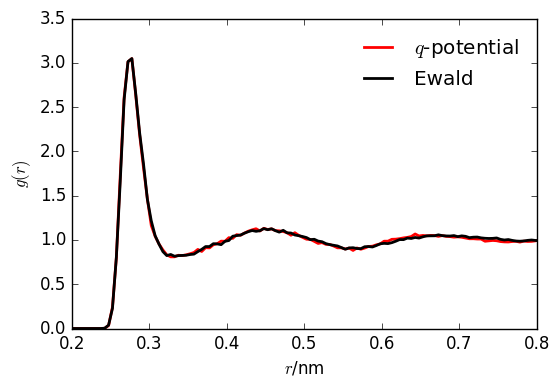

In [6]:
import mdtraj as md

for name, prop in systemlist.items():
    print(name)
    
    traj = md.load(name+'.dcd', top=name+'.pdb')
    print('    number of atoms    = %s' % traj.n_atoms)
    print('    number of residues = %s' % traj.n_residues)
    print('    number of frames   = %s' % traj.n_frames)

    sel = traj.top.select('name O')
    OOpairs = traj.top.select_pairs('name O', 'name O')
    rdf = md.compute_rdf( traj, pairs=OOpairs, bin_width=0.005, r_range=[0.2, boxlen/2/10] )
    plt.plot( rdf[0], rdf[1], label=prop['label'], color=prop['color'], lw=2)

plt.xlim(0.2, 0.8)
plt.xlabel(r'$r$/nm')
plt.ylabel(r'$g(r)$')
plt.legend(loc=0, frameon=False)

### Average potential energy

qpot
    avg. potential energy -9764.45378575  kJ/mol
ewald
    avg. potential energy -10091.3166734  kJ/mol


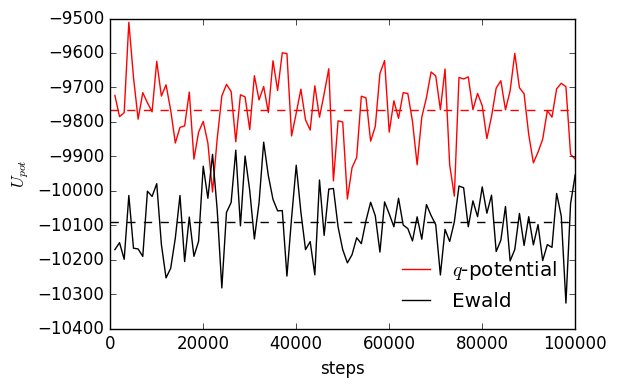

In [7]:
for name, prop in systemlist.items():
    print(name)
    step, Upot, temp, density = np.loadtxt(name+'.energy', skiprows=1, delimiter=',', unpack=True)
    plt.plot( step, Upot, label=prop['label'], color=prop['color'] )
    plt.plot( [0,step.max()], [Upot.mean(), Upot.mean()], color=prop['color'], ls='--', lw=1 )
    print('    avg. potential energy', Upot.mean(), ' kJ/mol')

plt.xlabel(r'steps')
plt.ylabel(r'$U_{pot}$')
plt.legend(loc=0, frameon=False)    

### Static dielectric constant

The exact formula is not given in the `mdtraj` documentation, but can be found in the source code on github,

https://github.com/mdtraj/mdtraj/blob/master/mdtraj/geometry/thermodynamic_properties.py#L90

In [10]:
def getChargeVector( force ):
    ''' Get partial charges for all particles '''
    chargelist = []
    Zndx = -1

    if isinstance(force, NonbondedForce):
        Zndx = 0
    if isinstance(force, CustomNonbondedForce):
        for i in range(len( force.getParticleParameters(0) )):
            if force.getPerParticleParameterName(i)=='charge':
                Zndx=i

    if Zndx>=0:
        chargelist = []
        for i in range( force.getNumParticles() ):
            charge = force.getParticleParameters( i )[ Zndx]       
            if isinstance(charge, Quantity):
                charge = charge / elementary_charge
            chargelist.append( charge )
        return chargelist

    return None
    
for name, prop in systemlist.items():
    print(name)
    for force in prop['system'].getForces():
        if isinstance(force, (NonbondedForce, CustomNonbondedForce) ):
            charges = getChargeVector( force )
            traj = md.load(name+'.dcd', top=name+'.pdb')

            l = len(traj)
            l2= int(l/2)
            eps1 = md.static_dielectric( traj[0:l2], charges, temperature=298.15) # 1st half
            eps2 = md.static_dielectric( traj[l2:l], charges, temperature=298.15) # 2nd half
            eps12= md.static_dielectric( traj[0:l], charges, temperature=298.15)  # both halfs = all
            
            print('   diel. const.', eps12, eps1, eps2)

qpot
   diel. const. 68.89323690321997 51.82492144796252 60.2962749844085
ewald
   diel. const. 50.6473196154984 45.448719487675184 41.70016198139066
